# BERTのメカニズム
BERTと呼ばれる深層学習モデルで7章と同じIMDbデータセットのポジネガ分析を行う  
  
BERTは2018年後半にGoogleが発表したNLP用深層学習モデル  
BERT=Bidirectional Encoder Representations from Transformers  
これまでのNLPモデルとは一線を画し，ブレークスルーのきっかけとなる期待を持たれている  

## BERTのモデル構造の概要
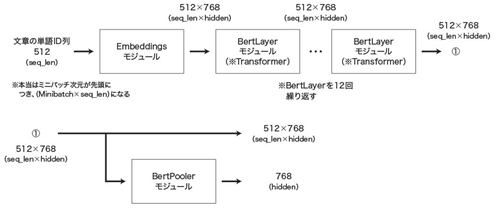